In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp /content/drive/My\ Drive/Workflows/* ./

In [0]:
#Place all imports here

import math
import xml.etree.ElementTree as ET
import copy
import statistics
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as BK
%matplotlib inline

In [0]:
#Place configs here
total_resources = 6
filename = 'Montage_25.xml'
K = 100
n = 13
b = 12
objectives = 5

RESOURCES = [
    {'type': 'm4.large', 'cu': 6.5, 'price': 0.1},
    {'type': 'm5.xlarge', 'cu': 16, 'price': 0.192},
    {'type': 'm5.2xlarge', 'cu': 31, 'price': 0.192},
    {'type': 'm5.4xlarge', 'cu': 60, 'price': 0.768},
    {'type': 'm5.12xlarge', 'cu': 173, 'price': 2.304},
    {'type': 'm5.24xlarge', 'cu': 345, 'price': 4.608}
]

In [0]:
class File:
    name = ''
    size = ''

    def __init__(self, name, size):
        self.name = name
        self.size = size

In [0]:
class Resource:
    id = 0
    type = ''
    cu = 0.0
    price = 0.0

    def __init__(self, id, type, cu, price):
        self.id = id
        self.type = type
        self.cu = cu
        self.price = price

In [0]:
class Task:
    id = ''
    runtime = 0.0
    input_files = list()
    output_files = list()
    predecessor_tasks = list()
    successor_tasks = list()

    def __init__(self, id, runtime):
        self.id = id
        self.runtime = runtime
        self.input_files = list()
        self.output_files = list()
        self.predecessor_tasks = list()
        self.successor_tasks = list()

    def add_input_file(self, file):
        self.input_files.append(file)

    def add_output_file(self, file):
        self.output_files.append(file)

    def add_predecessor_task(self, task):
        self.predecessor_tasks.append(task)

    def add_successor_task(self, task):
        self.successor_tasks.append(task)

In [0]:
class HyperVolume:
    """
    Hypervolume computation based on variant 3 of the algorithm in the paper:
    C. M. Fonseca, L. Paquete, and M. Lopez-Ibanez. An improved dimension-sweep
    algorithm for the hypervolume indicator. In IEEE Congress on Evolutionary
    Computation, pages 1157-1163, Vancouver, Canada, July 2006.

    Minimization is implicitly assumed here!

    """

    def __init__(self, referencePoint):
        """Constructor."""
        self.referencePoint = referencePoint
        self.list = []


    def compute(self, front):
        """Returns the hypervolume that is dominated by a non-dominated front.

        Before the HV computation, front and reference point are translated, so
        that the reference point is [0, ..., 0].

        """

        def weaklyDominates(point, other):
            for i in range(len(point)):
                if point[i] > other[i]:
                    return False
            return True

        relevantPoints = []
        referencePoint = self.referencePoint
        dimensions = len(referencePoint)
        for point in front:
            # only consider points that dominate the reference point
            if weaklyDominates(point, referencePoint):
                relevantPoints.append(point)
        if any(referencePoint):
            # shift points so that referencePoint == [0, ..., 0]
            # this way the reference point doesn't have to be explicitly used
            # in the HV computation
            for j in range(len(relevantPoints)):
                relevantPoints[j] = [relevantPoints[j][i] - referencePoint[i] for i in range(dimensions)]
        self.preProcess(relevantPoints)
        bounds = [-1.0e308] * dimensions
        hyperVolume = self.hvRecursive(dimensions - 1, len(relevantPoints), bounds)
        return hyperVolume


    def hvRecursive(self, dimIndex, length, bounds):
        """Recursive call to hypervolume calculation.

        In contrast to the paper, the code assumes that the reference point
        is [0, ..., 0]. This allows the avoidance of a few operations.

        """
        hvol = 0.0
        sentinel = self.list.sentinel
        if length == 0:
            return hvol
        elif dimIndex == 0:
            # special case: only one dimension
            # why using hypervolume at all?
            return -sentinel.next[0].cargo[0]
        elif dimIndex == 1:
            # special case: two dimensions, end recursion
            q = sentinel.next[1]
            h = q.cargo[0]
            p = q.next[1]
            while p is not sentinel:
                pCargo = p.cargo
                hvol += h * (q.cargo[1] - pCargo[1])
                if pCargo[0] < h:
                    h = pCargo[0]
                q = p
                p = q.next[1]
            hvol += h * q.cargo[1]
            return hvol
        else:
            remove = self.list.remove
            reinsert = self.list.reinsert
            hvRecursive = self.hvRecursive
            p = sentinel
            q = p.prev[dimIndex]
            while q.cargo != None:
                if q.ignore < dimIndex:
                    q.ignore = 0
                q = q.prev[dimIndex]
            q = p.prev[dimIndex]
            while length > 1 and (q.cargo[dimIndex] > bounds[dimIndex] or q.prev[dimIndex].cargo[dimIndex] >= bounds[dimIndex]):
                p = q
                remove(p, dimIndex, bounds)
                q = p.prev[dimIndex]
                length -= 1
            qArea = q.area
            qCargo = q.cargo
            qPrevDimIndex = q.prev[dimIndex]
            if length > 1:
                hvol = qPrevDimIndex.volume[dimIndex] + qPrevDimIndex.area[dimIndex] * (qCargo[dimIndex] - qPrevDimIndex.cargo[dimIndex])
            else:
                qArea[0] = 1
                qArea[1:dimIndex+1] = [qArea[i] * -qCargo[i] for i in range(dimIndex)]
            q.volume[dimIndex] = hvol
            if q.ignore >= dimIndex:
                qArea[dimIndex] = qPrevDimIndex.area[dimIndex]
            else:
                qArea[dimIndex] = hvRecursive(dimIndex - 1, length, bounds)
                if qArea[dimIndex] <= qPrevDimIndex.area[dimIndex]:
                    q.ignore = dimIndex
            while p is not sentinel:
                pCargoDimIndex = p.cargo[dimIndex]
                hvol += q.area[dimIndex] * (pCargoDimIndex - q.cargo[dimIndex])
                bounds[dimIndex] = pCargoDimIndex
                reinsert(p, dimIndex, bounds)
                length += 1
                q = p
                p = p.next[dimIndex]
                q.volume[dimIndex] = hvol
                if q.ignore >= dimIndex:
                    q.area[dimIndex] = q.prev[dimIndex].area[dimIndex]
                else:
                    q.area[dimIndex] = hvRecursive(dimIndex - 1, length, bounds)
                    if q.area[dimIndex] <= q.prev[dimIndex].area[dimIndex]:
                        q.ignore = dimIndex
            hvol -= q.area[dimIndex] * q.cargo[dimIndex]
            return hvol


    def preProcess(self, front):
        """Sets up the list data structure needed for calculation."""
        dimensions = len(self.referencePoint)
        nodeList = MultiList(dimensions)
        nodes = [MultiList.Node(dimensions, point) for point in front]
        for i in range(dimensions):
            self.sortByDimension(nodes, i)
            nodeList.extend(nodes, i)
        self.list = nodeList


    def sortByDimension(self, nodes, i):
        """Sorts the list of nodes by the i-th value of the contained points."""
        # build a list of tuples of (point[i], node)
        decorated = [(node.cargo[i], node) for node in nodes]
        # sort by this value
        sorted(decorated, key=lambda n: n[0])
        # write back to original list
        nodes[:] = [node for (_, node) in decorated]
            
            
            
class MultiList: 
    """A special data structure needed by FonsecaHyperVolume. 
    
    It consists of several doubly linked lists that share common nodes. So, 
    every node has multiple predecessors and successors, one in every list.

    """

    class Node: 
        
        def __init__(self, numberLists, cargo=None): 
            self.cargo = cargo 
            self.next  = [None] * numberLists
            self.prev = [None] * numberLists
            self.ignore = 0
            self.area = [0.0] * numberLists
            self.volume = [0.0] * numberLists
    
        def __str__(self): 
            return str(self.cargo)
        
        
    def __init__(self, numberLists):  
        """Constructor. 
        
        Builds 'numberLists' doubly linked lists.

        """
        self.numberLists = numberLists
        self.sentinel = MultiList.Node(numberLists)
        self.sentinel.next = [self.sentinel] * numberLists
        self.sentinel.prev = [self.sentinel] * numberLists  
        
        
    def __str__(self):
        strings = []
        for i in range(self.numberLists):
            currentList = []
            node = self.sentinel.next[i]
            while node != self.sentinel:
                currentList.append(str(node))
                node = node.next[i]
            strings.append(str(currentList))
        stringRepr = ""
        for string in strings:
            stringRepr += string + "\n"
        return stringRepr
    
    
    def __len__(self):
        """Returns the number of lists that are included in this MultiList."""
        return self.numberLists
    
    
    def getLength(self, i):
        """Returns the length of the i-th list."""
        length = 0
        sentinel = self.sentinel
        node = sentinel.next[i]
        while node != sentinel:
            length += 1
            node = node.next[i]
        return length
            
            
    def append(self, node, index):
        """Appends a node to the end of the list at the given index."""
        lastButOne = self.sentinel.prev[index]
        node.next[index] = self.sentinel
        node.prev[index] = lastButOne
        # set the last element as the new one
        self.sentinel.prev[index] = node
        lastButOne.next[index] = node
        
        
    def extend(self, nodes, index):
        """Extends the list at the given index with the nodes."""
        sentinel = self.sentinel
        for node in nodes:
            lastButOne = sentinel.prev[index]
            node.next[index] = sentinel
            node.prev[index] = lastButOne
            # set the last element as the new one
            sentinel.prev[index] = node
            lastButOne.next[index] = node
        
        
    def remove(self, node, index, bounds): 
        """Removes and returns 'node' from all lists in [0, 'index'[."""
        for i in range(index): 
            predecessor = node.prev[i]
            successor = node.next[i]
            predecessor.next[i] = successor
            successor.prev[i] = predecessor  
            if bounds[i] > node.cargo[i]:
                bounds[i] = node.cargo[i]
        return node
    
    
    def reinsert(self, node, index, bounds):
        """
        Inserts 'node' at the position it had in all lists in [0, 'index'[
        before it was removed. This method assumes that the next and previous 
        nodes of the node that is reinserted are in the list.

        """
        for i in range(index): 
            node.prev[i].next[i] = node
            node.next[i].prev[i] = node
            if bounds[i] > node.cargo[i]:
                bounds[i] = node.cargo[i]

In [0]:
class Workflow:
    id = 0
    workflow = list()
    processing_time = dict()
    makespan = 0
    total_cost = 0
    cost = dict()
    degree_of_imbalance = 0.0
    task_to_resource_dict = dict()
    billing_time = dict()
    rel_inverse = 1.0
    energy = 0.0

    def __init__(self):
        self.id = 0
        self.workflow = list()
        self.makespan = 0
        self.total_cost = 0
        self.processing_time = dict()
        self.cost = dict()
        self.degree_of_imbalance = 0
        self.task_to_resource_dict = dict()
        self.billing_time = dict()
        self.rel_inverse = 1.0
        self.energy = 0.0

    def add_to_workflow(self, task, resource):
        self.workflow.append((task, resource))
        self.task_to_resource_dict[task] = resource
        self.billing_time[resource] = 0

    def calculate_makespan(self, tasks_dict, resources_dict, dag_dict):
        processing_time = dict()
        start_time = dict()
        finish_time = dict()

        for (task, resource) in self.workflow:
            processing_time[task] = float(tasks_dict[task].runtime / resources_dict[resource].cu)
            self.processing_time[task] = processing_time[task]
            max_time = 0
            for predecessor in tasks_dict[task].predecessor_tasks:
                if self.task_to_resource_dict[predecessor] != resource:
                    max_time = max(max_time, dag_dict[predecessor][task]/(1024.0*1024*1024))
            processing_time[task] += max_time

        for (task, resource) in self.workflow:
            if len(tasks_dict[task].predecessor_tasks) == 0:
                finish_time[task] = processing_time[task]
            else:
                finish_time[task] = processing_time[task] + max([finish_time[x] for x in tasks_dict[task].predecessor_tasks])
            self.billing_time[resource] = max(self.billing_time[resource], finish_time[task])

        self.makespan = max(finish_time.values())


    def calculate_cost(self, tasks_dict, resources_dict, dag_dict):
        cost = dict()

        for resource in self.billing_time:
            cost[resource] = math.ceil(self.billing_time[resource]/3600) * resources_dict[resource].price
        self.cost = copy.deepcopy(cost)
        self.total_cost = sum(cost.values())


    def calculate_degree_of_imbalance(self, resources_dict):
        degree_of_imbalance = dict()

        for resource in resources_dict:
            degree_of_imbalance[resource] = 0

        for (task, resource) in self.workflow:
            degree_of_imbalance[resource] = degree_of_imbalance[resource] + self.processing_time[task]

        dib_min = min(list(degree_of_imbalance.values()))
        dib_max = max(list(degree_of_imbalance.values()))
        dib_avg = statistics.mean(degree_of_imbalance.values())

        self.degree_of_imbalance = (dib_max-dib_min)/dib_avg


    def calculate_reliability(self):
        reliability = dict()
        for task in self.processing_time:
            reliability[task] = float(np.exp(-np.power(self.processing_time[task]/n, b)))

        rel = 1.0
        for task in reliability:
            rel = rel * reliability[task]

        if rel != 0:
          self.rel_inverse = 1/rel
        else:
          self.rel_inverse = float('inf')


    def calculate_energy(self, tasks_dict, resources_dict, dag_dict):
        execution_energy = 0
        transfer_energy = 0

        for (task, resource) in self.workflow:
            execution_energy += (resources_dict[resource].id + 1) * 1 * self.processing_time[task]
            
            for predecessor in tasks_dict[task].predecessor_tasks:
                if resource != self.task_to_resource_dict[predecessor]:
                    transfer_energy += (resources_dict[self.task_to_resource_dict[predecessor]].id + 1) * (0.4 * 0.4 * 0.4) * dag_dict[predecessor][task]/(1024.0*1024*1024)
        
        self.energy = execution_energy + transfer_energy


    def schedule(self, id, tasks_dict, resources_dict, dag_dict):
        self.id = id
        self.calculate_makespan(tasks_dict, resources_dict, dag_dict)
        self.calculate_cost(tasks_dict, resources_dict, dag_dict)
        self.calculate_degree_of_imbalance(resources_dict)
        self.calculate_reliability()
        self.calculate_energy(tasks_dict, resources_dict, dag_dict)

    def get_sorted_workflow(self):
        t = copy.deepcopy(self.workflow)
        t.sort(key = lambda x: x[0])
        return [x[1] for x in t]

    def print(self, resources_dict):
        print("ID: {}\nMakespan: {}\nCost: {}\nReliability: {}\nDegree of Imbalance: {}".format(self.id, self.makespan, self.total_cost, self.rel_inverse, self.degree_of_imbalance))

In [0]:
#This cells return B-Rank

b_rank = dict()

def get_b_rank(tasks_dict, task):
    #recursive function to calculate b_rank
    rank = 0
    if len(tasks_dict[task].successor_tasks) > 0:
        rank = 1
    for successor in tasks_dict[task].successor_tasks:
        rank = max(rank, get_b_rank(tasks_dict, successor)+1)
    b_rank[task] = rank
    return rank

def calculate_b_rank(tasks_dict):
    #Driver function to get B-rank
    for task in tasks_dict:
        b_rank[task] = -1

    for task in tasks_dict:
        if b_rank[task] == -1:
            get_b_rank(tasks_dict, task)

    rank_list = list()

    for (x, y) in sorted(b_rank.items(), key = lambda kv:(kv[1], kv[0])):
        rank_list.append(x)

    return rank_list[::-1]


In [0]:
def sort_by_objective(schedule_list, objective):
    distance_dict = dict()
    values = list()

    if objective == 'makespan':
        schedule_list.sort(key = lambda x: x.makespan)
        values = [x.makespan for x in schedule_list]
    elif objective == 'cost':
        schedule_list.sort(key = lambda x: x.total_cost)
        values = [x.total_cost for x in schedule_list]
    elif objective == 'degree_of_imbalance':
        schedule_list.sort(key = lambda x: x.degree_of_imbalance)
        values = [x.degree_of_imbalance for x in schedule_list]
    elif objective == 'reliability':
        schedule_list.sort(key = lambda x: x.rel_inverse)
        values = [x.rel_inverse for x in schedule_list]
    elif objective == 'energy':
        schedule_list.sort(key = lambda x: x.energy)
        values = [x.energy for x in schedule_list]

    first_item = schedule_list[0]
    last_item = schedule_list[-1]

    first_value = values[0]
    last_value = values[-1]

    i = 1
    distance_dict = dict()

    while i < len(schedule_list)-1:
        if last_value-first_value != 0:
            dist = math.fabs((values[i+1] - values[i-1]) / (last_value - first_value))
        else:
            dist = 0

        distance_dict[schedule_list[i].id] =  dist
        i = i + 1

    return distance_dict, first_item, last_item

def crowding_distance_sort(schedule_list, K, objectives):
    makespan_distance_dict, first_item_makespan, last_item_makespan = sort_by_objective(schedule_list, 'makespan')
    cost_distance_dict, first_item_cost, last_item_cost = sort_by_objective(schedule_list, 'cost')
    degree_of_imbalance_distance_dict, first_item_degree_of_imbalance, last_item_degree_of_imbalance = sort_by_objective(schedule_list, 'degree_of_imbalance')
    reliability_distance_dict, first_item_rel, last_item_rel = sort_by_objective(schedule_list, 'reliability')
    energy_distance_dict, first_item_energy, last_item_energy = sort_by_objective(schedule_list, 'energy')

    objectives_id_list = list()
    boundary_items_list = list()
    crowding_distance = list()

    objectives_id_list.append(list(makespan_distance_dict.keys()))
    objectives_id_list.append(list(cost_distance_dict.keys()))
    boundary_items_list.append(first_item_makespan)
    boundary_items_list.append(last_item_makespan)
    boundary_items_list.append(first_item_cost)
    boundary_items_list.append(last_item_cost)

    if objectives > 2:
        objectives_id_list.append(list(degree_of_imbalance_distance_dict.keys()))
        boundary_items_list.append(first_item_degree_of_imbalance)
        boundary_items_list.append(last_item_degree_of_imbalance)
        if objectives > 3:
            objectives_id_list.append(list(reliability_distance_dict.keys()))
            boundary_items_list.append(first_item_rel)
            boundary_items_list.append(last_item_rel)
            if objectives > 4:
                objectives_id_list.append(list(energy_distance_dict.keys()))
                boundary_items_list.append(first_item_energy)
                boundary_items_list.append(last_item_energy)


    for id in objectives_id_list[0]:
        present = True
        for i in range(1, len(objectives_id_list)):
            if id not in objectives_id_list[i]:
                present = False
                break
        if present:
            distance = makespan_distance_dict[id] + cost_distance_dict[id]
            if objectives > 2:
                distance += degree_of_imbalance_distance_dict[id]
                if objectives > 3:
                    distance += reliability_distance_dict[id]
                    if objectives > 4:
                        distance += energy_distance_dict[id]
            crowding_distance.append((id, distance))


    sorted_crowding_distance = sorted(crowding_distance, key=lambda d: d[1], reverse=True)

    prior_list = []
    result = list()

    for item in boundary_items_list:
        if item.id not in [x.id for x in prior_list]:
            prior_list.append(item)

    if K >= len(prior_list):
        result.extend(prior_list)
        left_num = K - len(prior_list)
        j = 0
        while j < left_num and j < len(sorted_crowding_distance):
            individual_id = sorted_crowding_distance[j][0]

            for s in schedule_list:
                if s.id == individual_id:
                    result.append(s)
                    break
            j = j + 1
    else:
        result = prior_list[:K]
    return result


In [0]:
#Returns pareto solutions

def check_non_dominated(s1, s2, objectives):
    if objectives == 2:
        return ((s2.makespan <= s1.makespan and s2.total_cost < s1.total_cost) or (s2.makespan < s1.makespan and s2.total_cost <= s1.total_cost))
    if objectives == 3:
        return ((s2.makespan <= s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance) or (s2.makespan < s1.makespan and s2. total_cost <= s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance) or (s2.makespan < s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance <= s1.degree_of_imbalance))

    elif objectives == 4:
        return ((s2.makespan <= s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse) or (s2.makespan < s1.makespan and s2. total_cost <= s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse) or (s2.makespan < s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance <= s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse) or (s2.makespan < s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse <= s1.rel_inverse))
    
    elif objectives == 5:
        return ((s2.makespan <= s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse and s2.energy < s1.energy) or (s2.makespan < s1.makespan and s2. total_cost <= s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse and s2.energy < s1.energy) or (s2.makespan < s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance <= s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse and s2.energy < s1.energy) or (s2.makespan < s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse <= s1.rel_inverse and s2.energy < s1.energy) or (s2.makespan < s1.makespan and s2. total_cost < s1.total_cost and s2.degree_of_imbalance < s1.degree_of_imbalance and s2.rel_inverse < s1.rel_inverse and s2.energy <= s1.energy))

    

def get_pareto_result(schedules, objectives):
    pareto_list = list()

    if schedules is not None:
        for s1 in schedules:
            defeat = False

            for s2 in schedules:
                if s1.id != s2.id:
                    if(check_non_dominated(s1, s2, objectives)):  
                        defeat = True
                        break

            if defeat is False:
                pareto_list.append(s1)

    return pareto_list

In [0]:
def init_resources(total_resources):
    instance_per_resource = int(total_resources/len(RESOURCES))

    resources_dict = dict()
    id = 0

    for resource in RESOURCES:
        for i in range(instance_per_resource):
            resources_dict[id] = Resource(id = id, type = resource['type'], cu = resource['cu'], price = resource['price'])
            id = id + 1

    return resources_dict


In [0]:
def get_weight(successor_input_files, task_output_files):
    weight = 0
    for input_file in successor_input_files:
        for output_file in task_output_files:
            if input_file.name == output_file.name:
                weight = weight + max(input_file.size, output_file.size)

    return weight

def init_task_dag(tasks_dict):
    dag_dict = dict()

    for task in tasks_dict:
        temp = dict()
        for successor in tasks_dict[task].successor_tasks:
            temp[successor] = get_weight(tasks_dict[successor].input_files, tasks_dict[task].output_files)
        dag_dict[task] = temp

    return dag_dict


In [0]:
def init_tasks(filename):
    root = ET.parse(filename).getroot()
    tasks_dict = dict()

    for task in root.findall('./{http://pegasus.isi.edu/schema/DAX}job'):
        temp = Task(id = task.attrib['id'], runtime = float(task.attrib['runtime']))

        for file in task:
            if file.attrib['link'] == 'input':
                temp.add_input_file(File(name = file.attrib['file'], size = int(file.attrib['size'])))
            else:
                temp.add_output_file(File(name = file.attrib['file'], size = int(file.attrib['size'])))

        tasks_dict[temp.id] = temp

    for child in root.findall('./{http://pegasus.isi.edu/schema/DAX}child'):
        for parent in child:
            tasks_dict[child.attrib['ref']].add_predecessor_task(parent.attrib['ref'])
            tasks_dict[parent.attrib['ref']].add_successor_task(child.attrib['ref'])

    return tasks_dict

In [0]:
def moheft(tasks_dict, resources_dict, dag_dict, K, objectives):
    b_rank = calculate_b_rank(tasks_dict)

    schedules = list()

    for i in range(K):
        schedules.append(Workflow())

    for i in range(len(b_rank)):
        print("----Running iteration {}----".format(i+1))
        temp_list = list()

        if len(schedules) > 0:
            for s in schedules:
                for resource in resources_dict:
                    temp = copy.deepcopy(s)
                    temp.add_to_workflow(task = b_rank[i], resource = resource)
                    temp_list.append(temp)

        else:
            for resource in resources_dict:
                temp = copy.deepcopy(s)
                temp.add_to_workflow(task = b_rank[i], resource = resource)
                temp_list.append(temp)

        counter = 0
        for s in temp_list:
            s.schedule(counter, tasks_dict, resources_dict, dag_dict)
            counter = counter + 1
        schedules = crowding_distance_sort(temp_list, K, objectives)

    return get_pareto_result(schedules, objectives)


In [0]:
def get_dist(s1, s2, objectives):
    dist = math.pow((s1.makespan-s2.makespan),2) + math.pow((s1.total_cost-s2.total_cost),2)

    if objectives > 2:
        dist += math.pow((s1.degree_of_imbalance-s2.degree_of_imbalance),2)
        if objectives > 3:
          dist += math.pow((s1.rel_inverse-s2.rel_inverse),2)
          if objectives > 4:
              dist += math.pow((s1.energy - s2.energy), 2)
    return math.sqrt(dist)

def pair_solutions(S1, S2, objectives):
    pairs = list()

    if len(S1) <= len(S2):
        for s1 in S1:
            min_dist = -1
            id = 0
            for s2 in S2:
                dist = get_dist(s1, s2, objectives)
                if min_dist == -1 or dist < min_dist:
                    min_dist = dist
                    id = s2

            pairs.append((s1, id))
    else:
        for s2 in S2:
            min_dist = -1
            id = 0
            for s1 in S1:
                dist = get_dist(s1, s2, objectives)
                if min_dist == -1 or dist < min_dist:
                    min_dist = dist
                    id = s1

            pairs.append((id, s2))

    return pairs

In [0]:
def plot(pred, moh):
    y_data_1_makespan = set()
    y_data_2_makespan = set()
    y_data_1_cost = set()
    y_data_2_cost = set()
    for i in range(len(moh)):
        y_data_1_makespan.add(moh[i].makespan)
        y_data_1_cost.add(moh[i].total_cost)

    for i in range(len(pred)):
        y_data_2_makespan.add(pred[i].makespan)
        y_data_2_cost.add(pred[i].total_cost)

    y_data_1_makespan = list(y_data_1_makespan)
    y_data_1_cost = list(y_data_1_cost)
    y_data_2_makespan = list(y_data_2_makespan)
    y_data_2_cost = list(y_data_2_cost)

    plt.plot([i+1 for i in range(len(y_data_1_makespan))], sorted(y_data_1_makespan), c='red')
    plt.plot([i+1 for i in range(len(y_data_2_makespan))], sorted(y_data_2_makespan), c='blue')
    plt.show()
    plt.close()

    plt.plot([i+1 for i in range(len(y_data_1_cost))], sorted(y_data_1_cost), c='red')
    plt.plot([i+1 for i in range(len(y_data_2_cost))], sorted(y_data_2_cost), c='blue')
    plt.show()
    plt.close()

def plot_hv(predicted_hv, calculated_hv):
    x_data = list()

    for i in range(len(predicted_hv)):
        x_data.append(i)

    plt.plot(x_data, predicted_hv, c='red')
    plt.plot(x_data, calculated_hv[2:], c='yellow')
    plt.show()
    plt.close()

def plot_ns(predicted_solutions, moheft_solutions):
    x_data = list()

    for i in range(len(predicted_hv)):
        x_data.append(i)

    plt.plot(x_data, [len(x) for x in predicted_solutions], c='red')
    plt.plot(x_data, [len(x) for x in moheft_solutions[2:]], c='green')
    plt.show()
    plt.close()

In [0]:
def round_result(result):
    return_result = list()
    for a in result:
        return_result.append([round(x) for x in a])

    return return_result

In [0]:
def validate_solution(filename, result, tasks_dict, resources_dict, dag_dict, parent_solution, K, objectives):
    print(result)
    rounded_result = round_result(result)

    wf_list = list()

    BASE = 'ID000'
    id_list = list()

    for i in range(len(result[0])):
        if i < 10:
            id_list.append(BASE+'0'+str(i))
        else:
            id_list.append(BASE+str(i))

    for r in rounded_result:
        wf_list.append(Workflow())

    for i in range(len(wf_list)):
        for j in range(len(rounded_result[i])):
            wf_list[i].add_to_workflow(id_list[j], rounded_result[i][j] % max(resources_dict.keys()))

    # for k in range(len(parent_solution)):
    #     wf_list.append(Workflow())

    # for j in range(len(parent_solution)):
    #     for (task, resource) in parent_solution[j].workflow:
    #         wf_list[i+j+1].add_to_workflow(task, resource)

    j = 1
    counter = 0

    for p in parent_solution:
        sorted_parent = p.get_sorted_workflow()
        present = False
        for s in wf_list:
            sorted_new = s.get_sorted_workflow()
            if sorted_parent == sorted_new:
                counter += 1
                present = True
                break

        if present == False:
            wf_list.append(Workflow())
            for (task, resource) in p.workflow:
                wf_list[i+j].add_to_workflow(task, resource)

            j = j + 1

    print('Total {} duplicates found'.format(counter))

    for i in range(len(wf_list)):
        wf_list[i].schedule(i, tasks_dict, resources_dict, dag_dict)

    wf_list = crowding_distance_sort(wf_list, K, objectives)

    return get_pareto_result(wf_list, objectives)

In [0]:
def train_model(t1, t2):
    model = Sequential()
    model.add(Dense(units=2*len(t1[0]), activation='linear', input_dim=len(t1[0])))
    model.add(Dense(len(t1[0]),activation='linear'))
    model.compile(optimizer = 'adam', loss='mae', metrics=['accuracy'])
    history = model.fit(t1, t2, epochs = 100, batch_size = 10, verbose=0)
    result = model.predict(t2)
    return result.tolist()

In [124]:
print("----Generating Resources Dict1----")
resources_dict = init_resources(total_resources)

print("----Generating Tasks Dict----")
tasks_dict = init_tasks(filename = filename)

print("----Generating Dag Dict----")
dag_dict = init_task_dag(tasks_dict)

----Generating Resources Dict1----
----Generating Tasks Dict----
----Generating Dag Dict----


In [0]:
def calculate_hv(workflows, objectives):
    reference_point = list()
    for o in range(objectives):
      reference_point.append(1.1)
    hv = HyperVolume(reference_point)
    max_makespan = 0.0
    max_cost = 0.0
    max_dib = 0.0
    max_rel_inv = 0.0
    max_energy = 0.0
    fronts = list()

    for workflow in workflows:
        fronts.append(list())
        max_makespan = max(max_makespan, max([x.makespan for x in workflow]))
        max_cost = max(max_cost, max([x.total_cost for x in workflow]))
        max_dib = max(max_dib, max([x.degree_of_imbalance for x in workflow]))
        max_rel_inv = max(max_rel_inv, max([x.rel_inverse for x in workflow]))
        max_energy = max(max_energy, max([x.energy for x in workflow]))
        
    for i in range(len(workflows)):
        for s in workflows[i]:
            temp_list = [s.makespan/(max_makespan), s.total_cost/(max_cost)]
            if objectives > 2:
                temp_list.append(s.degree_of_imbalance/(max_dib))
                if objectives > 3:
                    temp_list.append(s.rel_inverse/max_rel_inv)
                    if objectives > 4:
                      temp_list.append(s.energy/(max_energy))
            fronts[i].append(temp_list)

    volumes = list()

    for front in fronts:
        volumes.append(hv.compute(front))

    return volumes

In [0]:
def frequency_of_change():
    solutions = list()
    predicted_solutions = list()
    K_list = [100, 200, 300, 400, 500]

    for k in K_list:
        print('----K = {}----'.format(k))
        solutions.append(moheft(tasks_dict, resources_dict, dag_dict, k, objectives))

    t1 = list()
    t2 = list()

    for i in range(len(K_list) -2):
        pairs = pair_solutions(solutions[i], solutions[i+1], objectives)
        for (x, y) in pairs:
            t1.append(x.get_sorted_workflow())
            t2.append(y.get_sorted_workflow())

        print('----Training----')
        result = train_model(t1, t2)
        predicted_solutions.append(validate_solution(filename, result, tasks_dict, resources_dict, dag_dict, solutions[i+1], K_list[i+1], objectives))
    
    return predicted_solutions, solutions

In [127]:
predicted_solutions, moheft_solutions = frequency_of_change()

----K = 100----
----Running iteration 1----
----Running iteration 2----
----Running iteration 3----
----Running iteration 4----
----Running iteration 5----
----Running iteration 6----
----Running iteration 7----
----Running iteration 8----
----Running iteration 9----
----Running iteration 10----
----Running iteration 11----
----Running iteration 12----
----Running iteration 13----
----Running iteration 14----
----Running iteration 15----
----Running iteration 16----
----Running iteration 17----
----Running iteration 18----
----Running iteration 19----
----Running iteration 20----
----Running iteration 21----
----Running iteration 22----
----Running iteration 23----
----Running iteration 24----
----Running iteration 25----
----K = 200----
----Running iteration 1----
----Running iteration 2----
----Running iteration 3----
----Running iteration 4----
----Running iteration 5----
----Running iteration 6----
----Running iteration 7----
----Running iteration 8----
----Running iteration 9----


In [128]:
predicted_hv = calculate_hv(predicted_solutions, objectives)
calculated_hv = calculate_hv(moheft_solutions, objectives)

print(predicted_hv)
print(calculated_hv)

[0.005715176668576626, 0.005715176668576667, 0.00571517666857662]
[0.0057151766685766495, 0.005715176668576616, 0.005715176668576665, 0.005715176668576662, 0.005715176668576648]


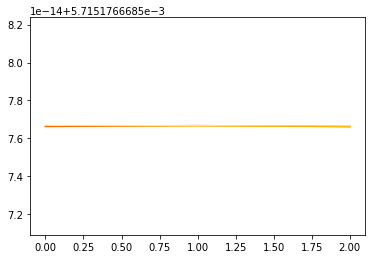

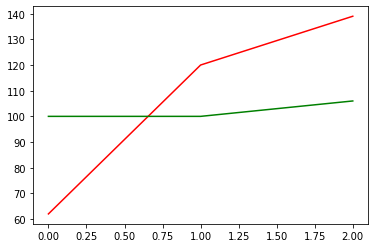

[0.005715176668576626, 0.005715176668576667, 0.00571517666857662]
[0.0057151766685766495, 0.005715176668576616, 0.005715176668576665, 0.005715176668576662, 0.005715176668576648]


In [129]:
plot_hv(predicted_hv, calculated_hv)
plot_ns(predicted_solutions, moheft_solutions)
print(predicted_hv)
print(calculated_hv)

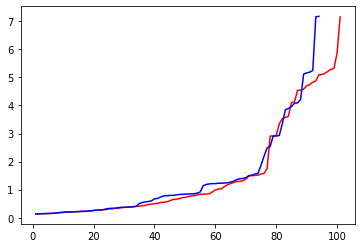

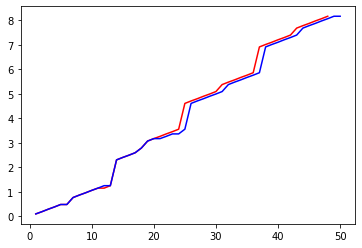

In [130]:
plot(predicted_solutions[-1], moheft_solutions[-1])